In [4]:
import gillespy2
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pysindy as ps
import cvxpy

# Seed the random number generators for reproducibility
np.random.seed(100)

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12


# The code is basically a copy from: https://pypi.org/project/gillespy2/
def create_gillespie_rna_model(M, c, max_time):
    """Gillespie algorithm for simulating one realization of RNA splicing dynamics.

    :param M: Initial state, numpy array with shape (2, 1).
    :param c: Vector of stochastic rate constants, list with length 3.
    :param max_time: Length of simulation time span, one number.

    :return:
        T - One-dimensional numpy array containing the reaction occurrence times.
        X - Two dimensional numpy array, where the rows contain the system state after each reaction.
    """
    # First call the gillespy2.Model initializer.
    model = gillespy2.Model(name='mRNA-splicing')

    # Define parameters for the rates of the reactions.
    c1 = gillespy2.Parameter(name='c1_transcription', expression=c[0])
    c2 = gillespy2.Parameter(name='c2_degrading', expression=c[1])
    c3 = gillespy2.Parameter(name='c3_expression', expression=c[2])
    model.add_parameter([c1, c2, c3])

    # Define variables for the molecular species representing M and D.
    x1 = gillespy2.Species(name='X1_unspliced_mRNA', initial_value=int(M[0]))
    x2 = gillespy2.Species(name='X2_spliced_mRNA', initial_value=int(M[1]))
    model.add_species([x1, x2])

    # The list of reactants and products for a Reaction object are each a
    # Python dictionary in which the dictionary keys are Species objects
    # and the values are stoichiometries of the species in the reaction.
    r1 = gillespy2.Reaction(name="r1_transcription", rate=c1, reactants={}, products={x1: 1})
    r2 = gillespy2.Reaction(name="r2_degrading", rate=c2, reactants={x2: 1}, products={})
    r3 = gillespy2.Reaction(name="r3_expression", rate=c3, reactants={x1: 1}, products={x2: 1})
    model.add_reaction([r1, r2, r3])

    # Set the timespan for the simulation.
    tspan = gillespy2.TimeSpan.linspace(t=max_time, num_points=1000)
    model.timespan(tspan)
    return model


def interpolate_to_fixed_timesteps(res, new_time_step):
    # Extract t, x, and y values
    t = res[:, 0]
    x = res[:, 1]
    y = res[:, 2]

    # Create a new time array with fixed time steps
    new_t = np.arange(min(t), max(t), new_time_step)

    # Interpolate x and y values for the new time steps
    x_interp = interp1d(t, x, kind='linear', fill_value='extrapolate')
    y_interp = interp1d(t, y, kind='linear', fill_value='extrapolate')

    # Generate new x and y values
    new_x = x_interp(new_t)
    new_y = y_interp(new_t)

    # Combine the new x, and new y into one array
    new_res = np.vstack((new_x, new_y)).T

    return new_res


def deterministic_rna(t, y, c1, c2, c3):
    y1, y2 = y
    return [c1 - c3 * y1, -c2 * y2 + c3 * y1]


def plot_model_prediction(model, x_test, dt, max_time):
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
    for i in range(x_test.shape[1]):
        axs[i].plot(np.arange(0, max_time, dt), x_dot_test_computed[:, i], "k", label="numerical derivative")
        axs[i].plot(np.arange(0, max_time, dt), x_dot_test_predicted[:, i], "r--", label="model prediction")
        axs[i].legend()
        axs[i].set(xlabel="t", ylabel=r"$\dot x_{}$".format(i))
    fig.show()


def get_true_rna_model(M, c, max_time, dt):
    t_eval = np.linspace(0, max_time, 200)
    sol = solve_ivp(deterministic_rna, [0, max_time], [M[0][0], M[1][0]], t_eval=t_eval, args=c)
    T = sol.t
    X = sol.y.T

    return interpolate_to_fixed_timesteps(np.vstack((T, X[:, 0], X[:, 1])).T, dt)



/home/jan/Documents/UNI/Aalto/Modeling Biological Networks/Modeling-Biological-Networks-Assignment/venv/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
dt = 0.1

M = np.array([[100, 10]]).T  # has shape (2, 1)
c = [10, 0.25, 0.5]
max_time = 20

print("Optimal Model")
print(f"(x0)' = {c[0]} 1 - {c[2]} x0")
print(f"(x1)' = {c[2]} x0 - {c[1]} x1")


Optimal Model
(x0)' = 10 1 - 0.5 x0
(x1)' = 0.5 x0 - 0.25 x1


/tmp/ipykernel_154604/724895337.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = gillespy2.Species(name='X1_unspliced_mRNA', initial_value=int(M[0]))
/tmp/ipykernel_154604/724895337.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = gillespy2.Species(name='X2_spliced_mRNA', initial_value=int(M[1]))


Unconstrained Model:
(x0)' = 10.560 1 + -0.588 x0
(x1)' = -7.239 1 + 0.558 x0 + -0.119 x1
Model score against true model: 0.938512


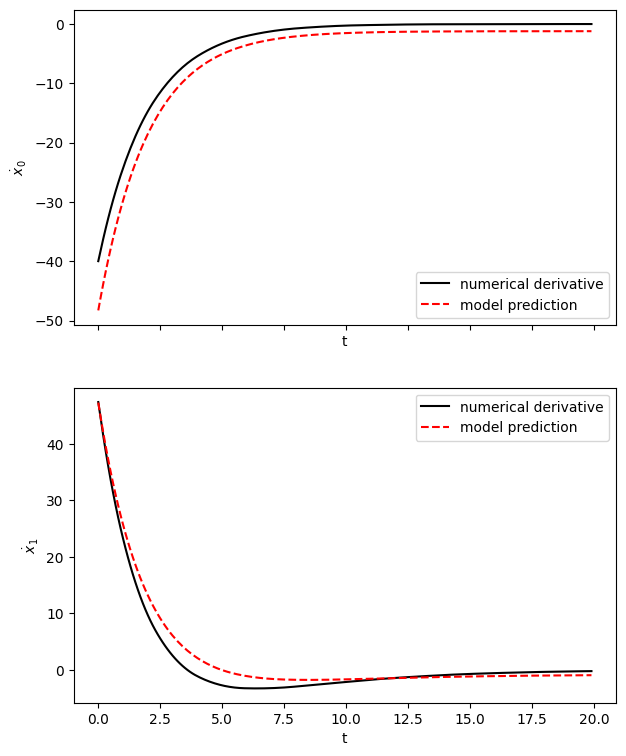

In [9]:
# Create the simulation_data
simulated_data = create_gillespie_rna_model(M, c, max_time).run(number_of_trajectories=1).to_array()

# Interpolate the data to be in fixed time steps
x_data = interpolate_to_fixed_timesteps(simulated_data[0], dt)

# Define the model with the custom optimizer
model_unconstrained = ps.SINDy()

model_unconstrained.fit(x_data, t=dt)
print("Unconstrained Model:")
model_unconstrained.print()

# True underlying model for reference
x_true = get_true_rna_model(M, c, max_time, dt)

print("Model score against true model: %f" % model_unconstrained.score(x_true, t=dt))
plot_model_prediction(model_unconstrained, x_true, dt, max_time)

In [11]:
print("Optimal Model")
print(f"(x0)' = {c[0]} 1 - {c[2]} x0")
print(f"(x1)' = {c[2]} x0 - {c[1]} x1")

# Create Model again with constraints
library = ps.PolynomialLibrary()
library.fit([ps.AxesArray(x_data, {"ax_sample": 0, "ax_coord": 1})])
n_features = library.n_output_features_
print(f"Features ({n_features}):", library.get_feature_names())

feature_pos = {feature: i for i, feature in enumerate(library.get_feature_names())}
feature_names = library.get_feature_names()
print(feature_pos)

Optimal Model
(x0)' = 10 1 - 0.5 x0
(x1)' = 0.5 x0 - 0.25 x1
Features (6): ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2']
{'1': 0, 'x0': 1, 'x1': 2, 'x0^2': 3, 'x0 x1': 4, 'x1^2': 5}


In [12]:
def pruned_model_optimizer_equality(prior_knowledge):
    """
    n_targets = number of variables that the system has
    prior_knowledge = define the ODE elements that you are certain about
        e.g. prior_knowledge = {
                                    # "feature_names":  ['1',   'x0',   'x1',   'x0^2', 'x0 x1',    'x1^2'],
                                    "x0":               [None,  None,   0,      0,      0,          0],
                                    "x1":               [0,     None,   None,   0,      0,          0]
                                }
        None: unknown connection -> no constrains for the model
        Number: This constant of the ODE needs to be this value
        
    """
    n_targets = len(prior_knowledge.keys())  # Every key is a target
    n_features = len(list(prior_knowledge.values())[0])  # All features that could exist and could have a constant

    # Set up the constraints for the optimizer
    constraint_rhs = np.array([])
    constraint_lhs = []
    for i_target, measured_variable in enumerate(prior_knowledge):

        constants_knowledge = prior_knowledge[measured_variable]
        for i_feature, const_val in enumerate(constants_knowledge):

            # None -> No knowledge about the connection. Don't add any constraints
            if const_val is None:
                continue

            # If we know something we need to append constraint_rhs with the value this constant should have
            constraint_rhs = np.append(constraint_rhs, np.array([const_val]))

            # The constraint_lhs needs to be the position of the model
            constraint = np.zeros((n_targets, n_features))
            constraint[i_target, i_feature] = 1
            constraint = np.array(constraint.flatten())

            constraint_lhs.append(constraint)

    optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, constraint_lhs=np.array(constraint_lhs))
    return optimizer

Equality Constrained Model
(x0)' = 10.560 1 + -0.588 x0
(x1)' = 0.502 x0 + -0.232 x1
Model score against true model: 0.951257


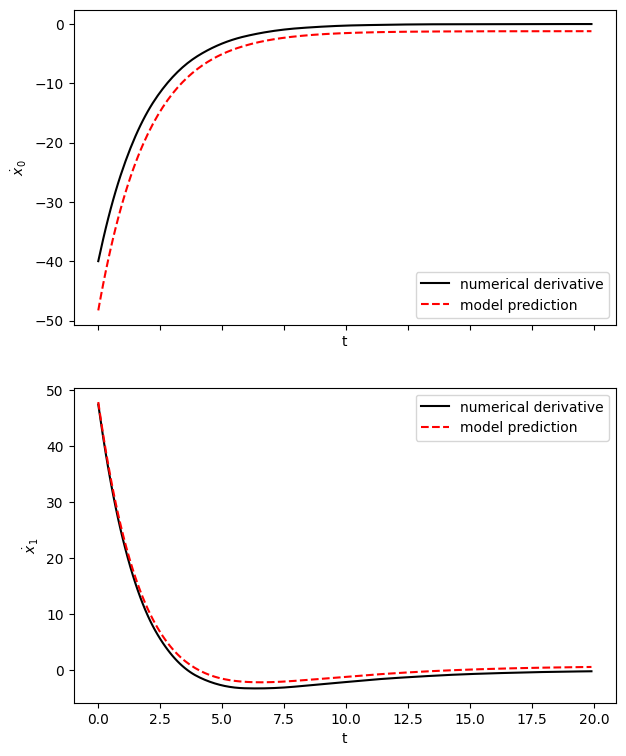

In [13]:
prior_model_knowledge = {
    # "feature_names":  ['1',   'x0',   'x1',   'x0^2', 'x0 x1',    'x1^2'],
    "x0": [None, None, 0, 0, 0, 0],
    "x1": [0, None, None, 0, 0, 0]
}

optimizer = pruned_model_optimizer_equality(prior_model_knowledge)
model_equality_constrained = ps.SINDy(optimizer=optimizer, feature_library=library)

model_equality_constrained.fit(x_data, t=dt)

print("Equality Constrained Model")
model_equality_constrained.print()

print("Model score against true model: %f" % model_equality_constrained.score(x_true, t=dt))
plot_model_prediction(model_equality_constrained, x_true, dt, max_time)

In [14]:
prior_model_knowledge = {
    # "feature_names":  ['1',   'x0',   'x1',   'x0^2', 'x0 x1',    'x1^2'],
    "x0": [None, None, 0, 0, 0, 0],
    "x1": [0, None, None, 0, 0, 0]
}


def pruned_model_optimizer_inequality(prior_knowledge, eps: float = 1e-3):
    """
    n_targets = number of variables that the system has
    prior_knowledge = define the ODE elements that you are certain about
        e.g. prior_knowledge = {
                                    # "feature_names":  ['1',   'x0',   'x1',   'x0^2', 'x0 x1',    'x1^2'],
                                    "x0":               [None,  None,   0,      0,      0,          0],  
                                    "x1":               [0,     None,   None,   0,      0,          0]
                                }
        None: unknown connection -> no constrains for the model
        Number: This constant of the ODE needs to be this value
        
    """
    n_targets = len(prior_knowledge.keys())  # Every key is a target
    n_features = len(list(prior_knowledge.values())[0])  # All features that could exist and could have a constant

    # Set up the constraints for the optimizer
    constraint_rhs = np.array([])
    constraint_lhs = []
    for i_target, measured_variable in enumerate(prior_knowledge):

        constants_knowledge = prior_knowledge[measured_variable]
        for i_feature, const_val in enumerate(constants_knowledge):

            # None -> No knowledge about the connection. Don't add any constraints
            if const_val is None:
                continue

            if const_val == 0:
                # Also add restriction from the bottom
                constraint_rhs = np.append(constraint_rhs, np.array([eps]))
                constraint = np.zeros((n_targets, n_features))
                constraint[i_target, i_feature] = -1
                constraint_lhs.append(np.array(constraint.flatten()))

            # coefficient <= const_val + eps
            constraint_rhs = np.append(constraint_rhs, np.array([const_val + eps]))  # Also add a small offset

            # The constraint_lhs needs to be the position of the model
            constraint = np.zeros((n_targets, n_features))
            constraint[i_target, i_feature] = 1

            constraint_lhs.append(np.array(constraint.flatten()))

    optimizer = ps.ConstrainedSR3(
            constraint_rhs=constraint_rhs,
            constraint_lhs=np.array(constraint_lhs),
            inequality_constraints=True,
            thresholder="l1",
            tol=1e-7,
            threshold=10,
            max_iter=10000
    )
    return optimizer

Equality Constrained Model
(x0)' = 10.469 1 + -0.586 x0
(x1)' = 0.502 x0 + -0.232 x1
Model score against true model: 0.951598


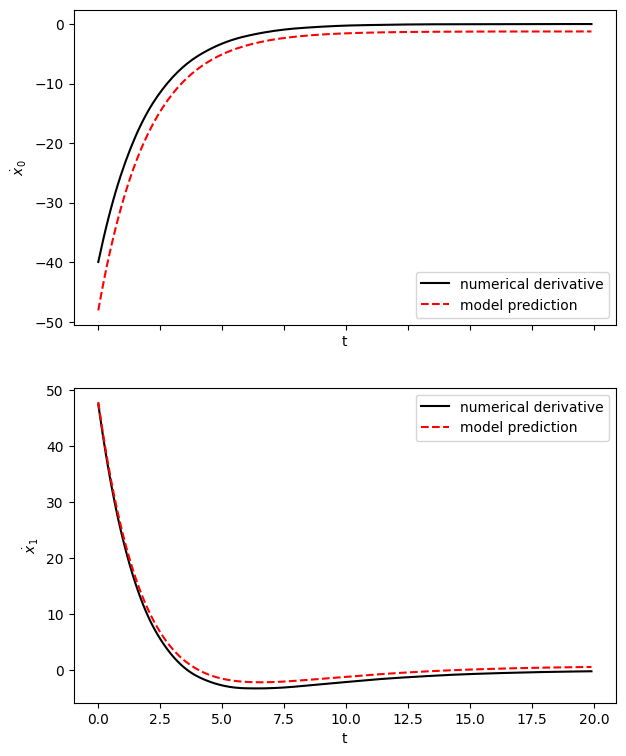

In [15]:
prior_model_knowledge = {
    # "feature_names":  ['1',   'x0',   'x1',   'x0^2', 'x0 x1',    'x1^2'],
    "x0": [None, None, 0, 0, 0, 0],
    "x1": [0, None, None, 0, 0, 0]
}

optimizer = pruned_model_optimizer_inequality(prior_model_knowledge, 1e-9)
model_inequality_constrained = ps.SINDy(optimizer=optimizer, feature_library=library)

model_inequality_constrained.fit(x_data, t=dt)

print("Equality Constrained Model")
model_inequality_constrained.print()

print("Model score against true model: %f" % model_inequality_constrained.score(x_true, t=dt))
plot_model_prediction(model_inequality_constrained, x_true, dt, max_time)

In [233]:
threshold_scan = np.linspace(0, 1, 21)
coefs = []
scores = []

for i, threshold in enumerate(threshold_scan):
    optimizer = ps.STLSQ(threshold=threshold)
    model_threshold = ps.SINDy(optimizer=optimizer, feature_library=library)

    model_threshold.fit(x_data, t=dt)
    scores.append(model_threshold.score(x_true, t=dt))

    coefs.append(model_threshold.coefficients())

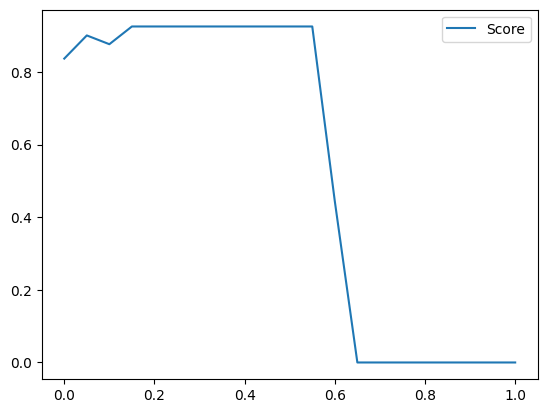

In [234]:
def plot_scores_over_threshold(threshold_scan, scores):
    plt.plot(threshold_scan, scores, label="Score")
    plt.legend()
    plt.show()


def plot_coefs_over_threshold(threshold_scan, coefs):
    coefs = np.array(coefs)

    fig, ax = plt.subplots(coefs.shape[1], coefs.shape[2], figsize=(30, 20))
    for i_target in range(coefs.shape[1]):
        for i_feature in range(coefs.shape[2]):
            ax[i_target, i_feature].plot(threshold_scan, coefs[:, i_target, i_feature], label="")
    plt.legend()
    plt.show()


plot_scores_over_threshold(threshold_scan, scores)
# plot_coefs_over_threshold(threshold_scan, coefs)

In [235]:
import networkx as nx
import matplotlib.pyplot as plt


def create_graph_from_model(model_equations):
    G = nx.DiGraph()

    # Add nodes and edges based on model equations
    for target, interactions in model_equations.items():
        for source, rate in interactions:
            if source == target:
                continue
            if rate == 0.0:
                continue

            if source == "1":
                source = f"{target} Source"

            G.add_edge(source, target, rate=rate)

    return G


def draw_graph(G):
    # Use a layout for dynamic structuring
    pos = nx.spring_layout(G, seed=42)  # For consistent layout across runs

    # Draw the graph with customized edges
    for edge in G.edges(data=True):
        source, target, data = edge
        rate = data['rate']

        # Determine color based on rate sign
        color = 'green' if rate > 0 else 'red'

        # Adjust thickness based on the absolute value of rate, ensuring a minimum thickness
        thickness = max(abs(rate) * 2, 0.5)

        nx.draw_networkx_edges(G, pos, edgelist=[(source, target)], width=thickness, edge_color=color, arrowsize=50)

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue")
    nx.draw_networkx_labels(G, pos)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'rate')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Dynamically Structured Graph from PySINDy Model")
    plt.axis('off')
    plt.show()

In [236]:
def format_model_for_graph_plot(pysindy_model):
    coef = np.array(pysindy_model.coefficients())

    feature_names = library.get_feature_names()

    model_equations = {}
    for i in range(coef.shape[0]):
        target = f"x{i}"
        model_equations[target] = []
        for j in range(coef.shape[1]):
            model_equations[target].append((feature_names[j], round(coef[i, j], 3)))

    return model_equations


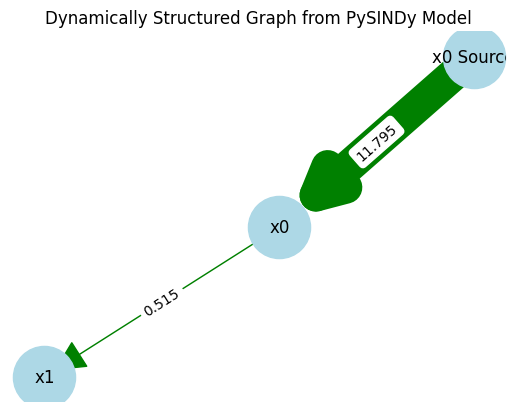

In [243]:
model_equations = format_model_for_graph_plot(model_inequality_constrained)

# Create the graph from model equations
G = create_graph_from_model(model_equations)

# Draw the graph with adapted edge thickness and color
draw_graph(G)

In [25]:
rna_to_element_translation: dict = {
    "SWI5": "x0",
    "CBF1": "x1",
    "GAL4": "x2",
    "GAL80": "x3",
    "ASH1": "x4"
}

model_quadratic_constants_combinations = {
    "SWI5": ["1", "SWI5", "GAL4", "SWI5^2", "GAL4^2"],
    "CBF1": ["1", "SWI5", "ASH1", "SWI5 ASH1", "SWI5^2", "ASH1^2"],
    "GAL4": ["1", "CBF1", "GAL80", "CBF1^2", "GAL80^2"],
    "GAL80": ["1", "SWI5", "SWI5^2"],
    "ASH1": ["1", "SWI5", "SWI5^2"]
}

In [26]:
import re


def translate_string(input_string, translation_dict):
    # Use a regular expression to replace each key with its corresponding value
    for key, value in translation_dict.items():
        input_string = re.sub(r'\b' + key + r'\b', value, input_string)
    return input_string


def translate_model_definition_to_spare_array(rna_to_element_translation, feature_names, model_description):
    translated_model = {f"x{i}": [] for i in range(len(model_description))}

    for rna_name, target_values in model_description.items():
        target = rna_to_element_translation[rna_name]

        target_features = []
        for feature_name in feature_names:
            translated_feature_name = translate_string(feature_name, rna_to_element_translation)

            val = 0

            if translated_feature_name in target_values:
                val = None

            # Check if the order needs to be switched
            if " " in target_values and " ".join(list(reversed(translated_feature_name.split(" ")))) in target_values:
                val = None

            target_features.append(val)

        translated_model[target] = target_features

    return translated_model


feature_names = ['1', 'x0', 'x1', 'x2', 'x3', 'x4', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x1^2', 'x1 x2',
                 'x1 x3', 'x1 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2']
prior_model_knowledge = translate_model_definition_to_spare_array(rna_to_element_translation, feature_names,
                                                                  model_quadratic_constants_combinations)

print(prior_model_knowledge)

{'x0': [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'x1': [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'x2': [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'x3': [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'x4': [None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
